In [83]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import imblearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim

In [84]:
data = pd.read_csv("weatherAUS.csv")
df = data.copy()

In [85]:
df.drop(['Evaporation','Sunshine',"Cloud9am","Cloud3pm"],axis=1,inplace=True)
df.dropna(axis=0,inplace=True)

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

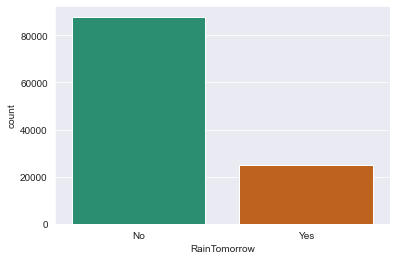

In [105]:
sns.set_style('darkgrid')
sns.countplot(x='RainTomorrow', data=df, palette='Dark2') 

In [87]:
y = df['RainTomorrow']
df_date = df[['Date']]
df_chr = df.drop(['RainTomorrow','Date'],axis=1).select_dtypes(exclude=np.number)
df_num = df.select_dtypes(include=np.number)

In [88]:
num_cols = df_num.columns
R_scaler = RobustScaler()
df_num_rs = R_scaler.fit(df_num).transform(df_num)
df_num_rs = pd.DataFrame(data = df_num_rs, columns = num_cols)

df_chr = pd.get_dummies(df_chr,drop_first=True)
y= pd.get_dummies(y,drop_first=True)
df_chr.reset_index(inplace=True)

df_date['Year'] = pd.to_numeric(df_date['Date'].str[:4])
df_date['Month'] = pd.to_numeric(df_date['Date'].str[5:7])
df_date['Day'] = pd.to_numeric(df_date['Date'].str[8:10])
df_date.drop(['Date'],axis=1,inplace=True)
date_cols = df_date.columns
R_scaler = RobustScaler()
df_date_rs = R_scaler.fit(df_date).transform(df_date)
df_date_rs = pd.DataFrame(data = df_date_rs, columns = date_cols)

X = pd.concat([df_chr,df_num_rs,df_date_rs],axis=1)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [89]:
X = X[['Humidity3pm','RainToday_Yes',"Humidity9am","WindGustSpeed",'Pressure9am','Pressure3pm',"Temp3pm","Temp9am","MinTemp","MaxTemp"]]

In [106]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=0.5)
X, y = oversample.fit_resample(X, y)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101,stratify=y)

# Modelling parametres

In [108]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## Define Custom Dataloaders

In [129]:
X_train

tensor([[ 0.4483,  1.0000,  1.2800,  ...,  0.3011,  0.7033,  0.1442],
        [ 0.9310,  0.0000, -0.2400,  ...,  0.3226,  0.3956, -0.1058],
        [-0.5517,  1.0000,  1.0400,  ..., -0.1290, -0.0110,  0.5481],
        ...,
        [-0.2414,  0.0000,  0.1200,  ..., -0.6022, -0.3077, -0.5962],
        [-0.6207,  0.0000, -0.4800,  ...,  1.2366,  1.3956,  1.2500],
        [ 0.9655,  0.0000,  0.7600,  ..., -0.3978, -0.1648, -0.6635]])

In [128]:
#coverting arrayes into torch
X_train=torch.from_numpy(X_train.values).float()
X_test=torch.from_numpy(X_test.values).float()
y_train=torch.from_numpy(y_train.values).float()
y_test=torch.from_numpy(y_test.values).float()

In [110]:
#creating a Tensor Datasets
train_data=TensorDataset(X_train , y_train)
test_data=TensorDataset(X_test , y_test)

In [111]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

# Creating NN model

In [119]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(len(X.columns), 1000) 
        self.layer_2 = nn.Linear(1000, 499)
        self.layer_out = nn.Linear(499, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1000)
        self.batchnorm2 = nn.BatchNorm1d(499)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [121]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=10, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=499, bias=True)
  (layer_out): Linear(in_features=499, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(499, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [122]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [123]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.float())
        acc = binary_acc(y_pred, y_batch.float())
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.43123 | Acc: 80.445
Epoch 002: | Loss: 0.41785 | Acc: 80.995
Epoch 003: | Loss: 0.41389 | Acc: 81.221
Epoch 004: | Loss: 0.41206 | Acc: 81.217
Epoch 005: | Loss: 0.41054 | Acc: 81.375
Epoch 006: | Loss: 0.40886 | Acc: 81.413
Epoch 007: | Loss: 0.40737 | Acc: 81.578
Epoch 008: | Loss: 0.40612 | Acc: 81.528
Epoch 009: | Loss: 0.40445 | Acc: 81.487
Epoch 010: | Loss: 0.40356 | Acc: 81.633
Epoch 011: | Loss: 0.40271 | Acc: 81.629
Epoch 012: | Loss: 0.40167 | Acc: 81.643
Epoch 013: | Loss: 0.39917 | Acc: 81.820
Epoch 014: | Loss: 0.39884 | Acc: 81.930
Epoch 015: | Loss: 0.39794 | Acc: 81.861
Epoch 016: | Loss: 0.39689 | Acc: 81.993
Epoch 017: | Loss: 0.39607 | Acc: 82.004
Epoch 018: | Loss: 0.39597 | Acc: 82.009
Epoch 019: | Loss: 0.39527 | Acc: 81.970
Epoch 020: | Loss: 0.39408 | Acc: 82.076
Epoch 021: | Loss: 0.39309 | Acc: 82.059
Epoch 022: | Loss: 0.39153 | Acc: 82.306
Epoch 023: | Loss: 0.39182 | Acc: 82.104
Epoch 024: | Loss: 0.39072 | Acc: 82.208
Epoch 025: | Los

In [124]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [125]:
print(confusion_matrix(y_test, y_pred_list))
print('\n',classification_report( y_test, y_pred_list))


[[26238  2771]
 [ 5026  9479]]

               precision    recall  f1-score   support

         0.0       0.84      0.90      0.87     29009
         1.0       0.77      0.65      0.71     14505

    accuracy                           0.82     43514
   macro avg       0.81      0.78      0.79     43514
weighted avg       0.82      0.82      0.82     43514

